In [3]:
import random
import math

class Period:
    
    def __init__(self):
        self.profit = None
        self.inflow = None
    
class Turbine:
    
    def __init__(self):
        self.efficiency = None
        self.minimum_discharge = None
        self.maximum_discharge = None
        self.minimum_production = None
        self.maximum_production = None

class HucInstance:
    
    def __init__(self, number_of_periods, number_of_turbines):
        # Periods.
        self.periods = [Period() for _ in range(number_of_periods)]
        # Turbines.
        self.turbines = [Turbine() for _ in range(number_of_turbines)]
        # Minimum volume in the reservoir.
        self.minimum_volume = None
        # Initial volume in the reservoir.
        self.initial_volume = None
        # Maximum volume in the reservoir.
        self.maximum_volume = None
        # Coefficients of the headwater function.
        a_head = None
        b_head = None
        # Coefficients of the tailwater function.
        a_tail_q = None
        a_tail_s = None
        b_tail = None
        
        # Fill some data.
        random.seed(number_of_periods * number_of_turbines)
        self.minimum_volume = 5e6
        self.maximum_volume = 30e6
        self.initial_volume = 25e6
        self.final_volume = 25e6
        self.a_head = 1e-07
        self.b_head = 50
        self.a_tail_q = 0.005
        self.a_tail_s = 0.001
        self.b_tail = 30
        for turbine in self.turbines:
            # 0 <= minimum_production <= maximum_production <= 50
            turbine.minimum_production = random.uniform(0, 10)
            turbine.maximum_production = turbine.minimum_production + random.uniform(0, 40)
            # 0 <= minimum_discharge <= maximum_discharge <= 100
            turbine.minimum_discharge = random.triangular(0, 100, 10)
            mode = max(turbine.minimum_discharge, 90)
            turbine.maximum_discharge = random.triangular(turbine.minimum_discharge, 100, mode)
            # 0.5 * rho_water * g <= efficiency <= 0.9 * rho_water * g
            turbine.efficiency = random.uniform(0.5, 0.9) * 0.000001 * 1000 * 9.81
        for t, period in enumerate(self.periods):
            # 10 <= inflow <= 100
            period.inflow = random.uniform(10, 100) * number_of_turbines
            # 10 <= profit <= 100
            ref = 40 * (1 + math.cos(t / 24 * 2 * math.pi)) + 10
            period.profit = ref + random.uniform(-10, 10)

In [10]:
import pyomo.environ as pyo

n = 10
h = 168
instance = HucInstance(h, n)

# Create a model
model = pyo.ConcreteModel()

####################
# Create variables #
####################

model.N = pyo.RangeSet(0, n - 1)
model.H = pyo.RangeSet(0, h - 1)

# Variables x_{j, t}.
model.x = pyo.Var(model.N, model.H, within=pyo.Binary)

# Variables q_{j, t}.
model.q = pyo.Var(model.N, model.H, within=pyo.NonNegativeReals)

# Variables p_{j, t}
model.p = pyo.Var(model.N, model.H, within=pyo.NonNegativeReals)

# Variables q_t.
model.qtot = pyo.Var(model.H, within=pyo.NonNegativeReals)

# Variables s_t.
model.s = pyo.Var(model.H, within=pyo.NonNegativeReals)

# Variables v_t.
model.v = pyo.Var(model.H, within=pyo.NonNegativeReals, bounds=(instance.minimum_volume, instance.maximum_volume))

# Variables h^\text{head}_t.
model.h_head = pyo.Var(model.H, within=pyo.Reals)

# Variables h^\text{tail}_t.
model.h_tail = pyo.Var(model.H, within=pyo.Reals)

# Variables h^\text{net}_t.
model.h_net = pyo.Var(model.H, within=pyo.NonNegativeReals)

#############
# Objective #
#############

model.objective = pyo.Objective(
        expr=pyo.quicksum(instance.periods[t].profit * model.p[j,t]
                      for j in model.N
                      for t in model.H),
        sense=pyo.maximize)

###############
# Constraints #
###############

# Constraints: water balance.
def water_balance_rule(model, t):
    return model.v[t] == model.v[t - 1] + 3600 * instance.periods[t].inflow - 3600 * model.qtot[t] - 3600 * model.s[t]
model.constraints_water_balance = pyo.Constraint(pyo.RangeSet(1, h - 1), rule=water_balance_rule)

# Constraints: minimum production
def minimum_production_rule(model, t, j):
    return model.p[j,t] >= instance.turbines[j].minimum_production * model.x[j,t]
model.constraints_minimum_production = pyo.Constraint(model.H, model.N, rule=minimum_production_rule)

# Constraints: maximum production
def maximum_production_rule(model, t, j):
    return model.p[j,t] <= instance.turbines[j].maximum_production * model.x[j,t]
model.constraints_maximum_production = pyo.Constraint(model.H, model.N, rule=maximum_production_rule)

# Constraints: minimum discharge
def minimum_discharge_rule(model, t, j):
    return model.q[j,t] >= instance.turbines[j].minimum_discharge * model.x[j,t]
model.constraints_minimum_discharge = pyo.Constraint(model.H, model.N, rule=minimum_discharge_rule)

# Constraints: maximum discharge
def maximum_discharge_rule(model, t, j):
    return model.q[j,t] <= instance.turbines[j].maximum_discharge * model.x[j,t]
model.constraints_maximum_discharge = pyo.Constraint(model.H, model.N, rule=maximum_discharge_rule)

# Constraints: total water discharge.
def total_water_discharge_rule(model, t):
    return model.qtot[t] == pyo.quicksum(model.q[j,t] for j in model.N)
model.constraints_total_water_discharge = pyo.Constraint(model.H, rule=total_water_discharge_rule)

# Constraints: headwater
def headwater_rule(model, t):
    return model.h_head[t] == instance.a_head * model.v[t] + instance.b_head
model.constraints_headwater = pyo.Constraint(model.H, rule=headwater_rule)

# Constraints: tailwater
# For all t = 1, ..., H, h_t^\text{tail} = A^\text{tail}_q q^\text{tot}_t + A^\text{tail}_s s_t + B^\text{tail}
def tailwater_rule(model, t):
    return model.h_tail[t] == instance.a_tail_q * model.qtot[t] + instance.a_tail_s * model.s[t] + instance.b_tail
model.constraints_tailwater = pyo.Constraint(model.H, rule=tailwater_rule)

# Constraints: nethead
def nethead_rule(model, t):
    return model.h_net[t] == model.h_head[t] - model.h_tail[t]
model.constraints_nethead = pyo.Constraint(model.H, rule=nethead_rule)

# Constraints: hydropower production function
# For all j = 1, ..., N, for all t = 1, ..., H, p_{j, t} <= eta_j q_{j,t} h^\text{net}_{t} $$
def hydropower_production_rule(model, t, j):
    return model.p[j, t] == instance.turbines[j].efficiency * model.q[j, t] * model.h_net[t]
model.constraints_hydropower_production = pyo.Constraint(model.H, model.N, rule=hydropower_production_rule)

# Constraint: initial conditions.
model.constraint_initial_volume = pyo.Constraint(expr=model.v[0] == instance.initial_volume)
model.constraint_final_volume = pyo.Constraint(expr=model.v[h - 1] >= instance.initial_volume)
model.constraint_initial_spilled_water = pyo.Constraint(expr=model.s[0] == 0)
def initial_discharge_rule(model, j):
    return model.q[j, 0] == 0
model.constraints_initial_discharge = pyo.Constraint(model.N, rule=initial_discharge_rule)

# Solve with cplex.
solver = pyo.SolverFactory('cplex')
# solver.options["mip_opt_gap_rel"] = 1
# solver.options["numthreads"] = 1
results = solver.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.6.3.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2015.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\URIEL~1.LEZ\AppData\Local\Temp\tmpp0zjlsxe.cplex.log' open.
CPLEX> Problem 'C:\Users\URIEL~1.LEZ\AppData\Local\Temp\tmpd3g96q_k.pyomo.lp' read.
Read time = 0.02 sec. (0.87 ticks)
CPLEX> Problem name         : C:\Users\URIEL~1.LEZ\AppData\Local\Temp\tmpd3g96q_k.pyomo.lp
Objective sense      : Maximize
Variables            :    6048  [Nneg: 3864,  Box: 168,  Free: 336,
                                 Binary: 1680]
Objective nonzeros   :    1680
Linear constraints   :    9252  [Less: 6720,  Greater: 1,  Equal: 2531]
  Nonzeros           :   20673
  RHS nonzeros       :     505

Variable

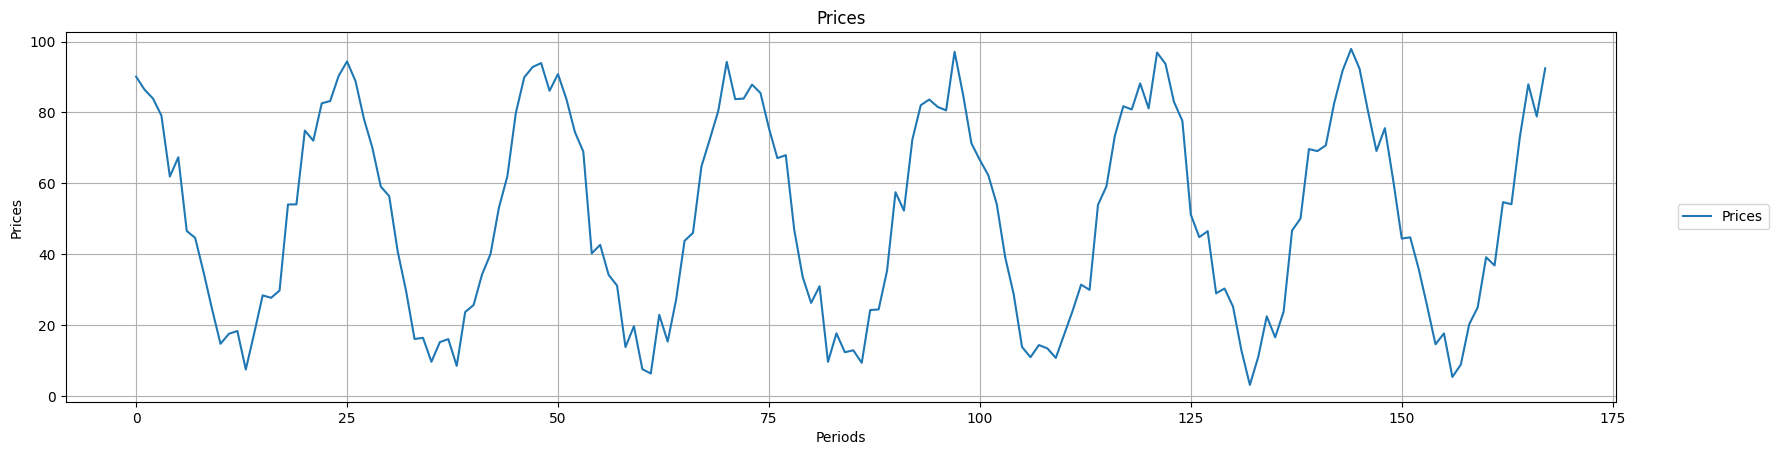

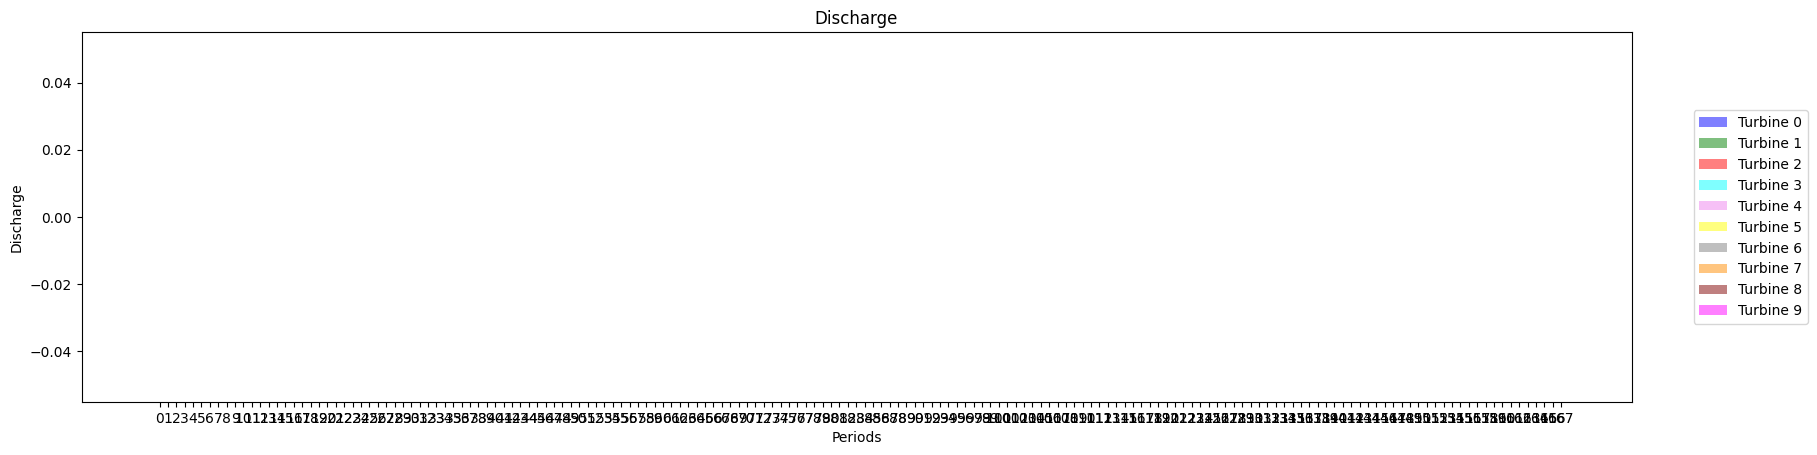

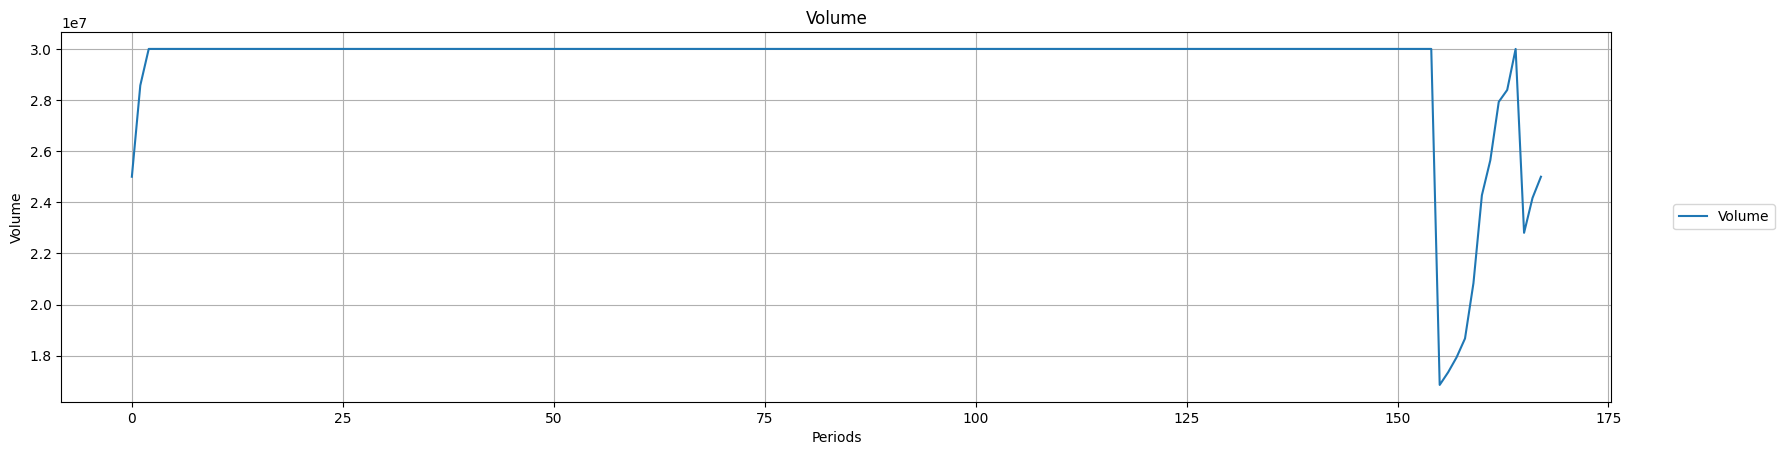

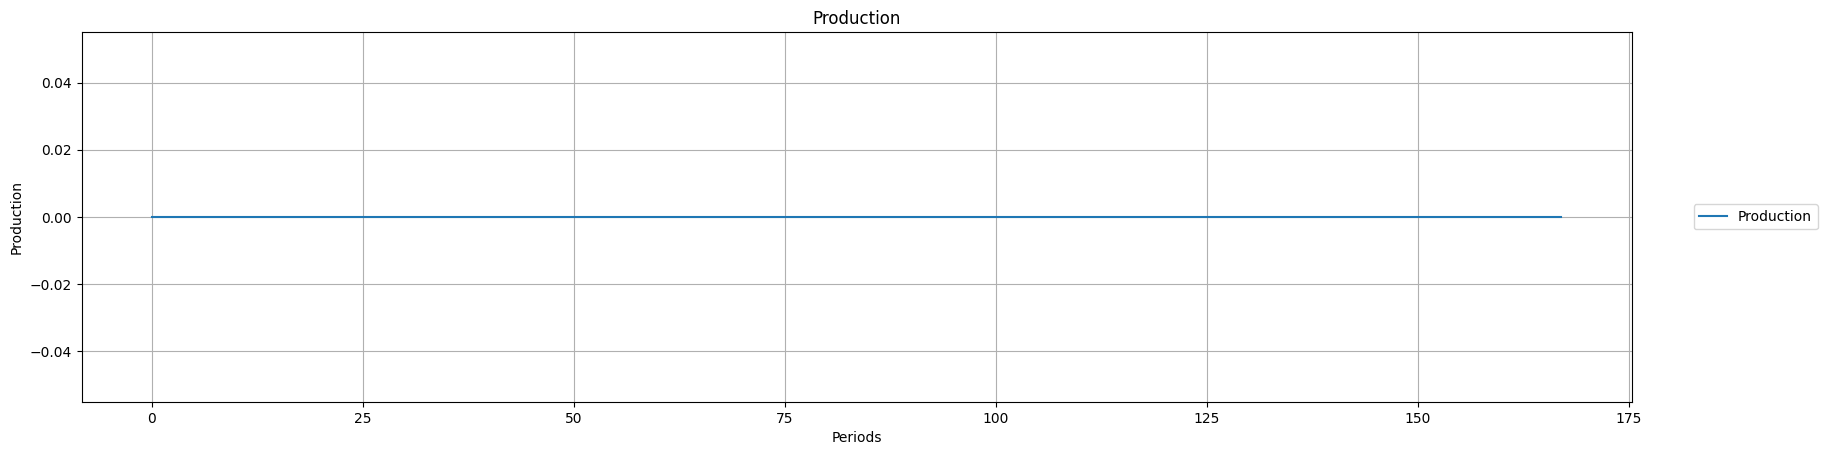

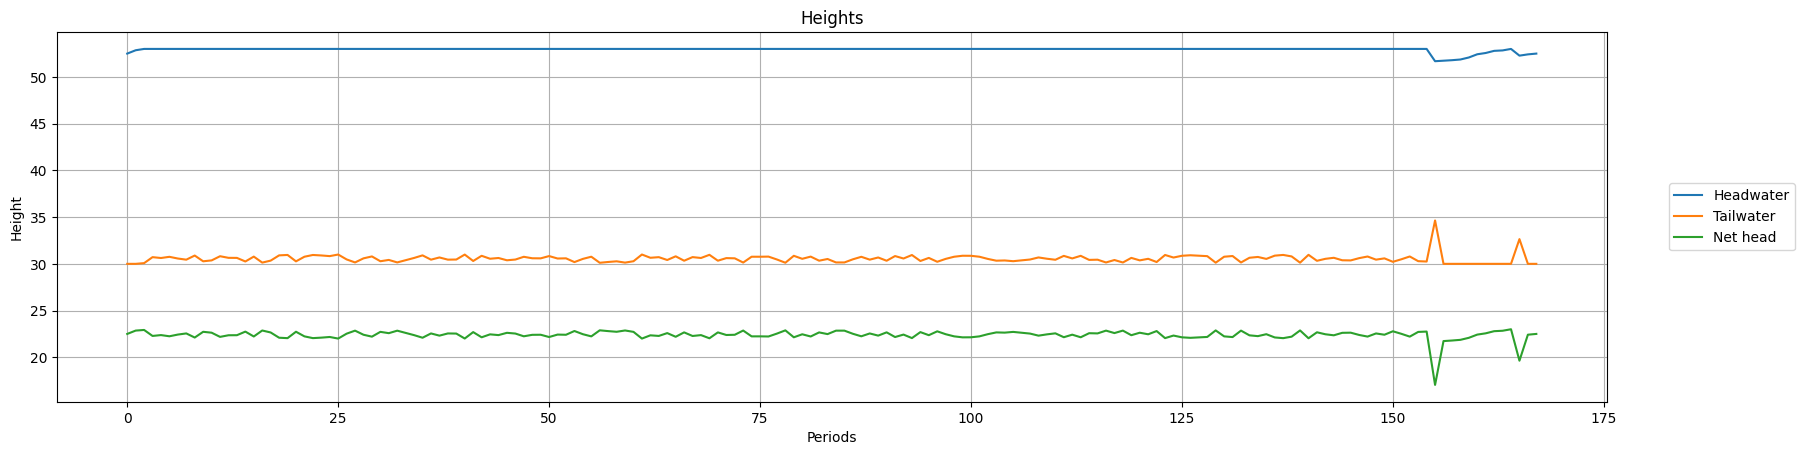

In [11]:
import matplotlib.pyplot as plt
import numpy as np

figwidth = 20
indices = np.arange(h)

# Plot prices.
plt.figure().set_figwidth(figwidth)
plt.plot(indices,
         [instance.periods[t].profit for t in range(h)],
         label="Prices")
plt.grid(True)
plt.ylabel("Prices")
plt.xlabel("Periods")
plt.title("Prices")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot solution, discharge for each turbine.
plt.figure().set_figwidth(figwidth)
width = 0.9
colors = ['blue', 'green', 'red', 'cyan', 'violet',"yellow","grey","darkorange","maroon","magenta","lightblue","lightcoral","bisque","slateblue"]
bottom = [0 for _ in range(h)]
for j in range(n):
    values = [model.q[j,t]() for t in range(h)]
    plt.bar(indices,
            values,
            width=width,
            alpha=0.5,
            color=colors[j],
            label="Turbine " + str(j),
            bottom=bottom)
    plt.xticks(indices + .5 * width,
               ['{}'.format(idx) for idx in range(h)])
    for t in range(h):
        bottom[t] += values[t]
plt.title("Discharge")
plt.xlabel("Periods")
plt.ylabel("Discharge")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot reservoir volume.
plt.figure().set_figwidth(figwidth)
plt.plot(indices,
         [model.v[t]() for t in range(h)],
         label="Volume")
plt.grid(True)
plt.ylabel("Volume")
plt.xlabel("Periods")
plt.title("Volume")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot production.
plt.figure().set_figwidth(figwidth)
plt.plot(indices,
         [sum(model.p[j,t]() for j in range(n)) for t in range(h)],
         label="Production")
plt.grid(True)
plt.ylabel("Production")
plt.xlabel("Periods")
plt.title("Production")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot headwater, tailwater and net head.
plt.figure().set_figwidth(figwidth)
plt.plot(indices,
         [model.h_head[t]() for t in indices],
         label="Headwater")
plt.plot(indices,
         [model.h_tail[t]() for t in indices],
         label="Tailwater")
plt.plot(indices,
         [model.h_net[t]() for t in indices],
         label="Net head")
plt.grid(True)
plt.ylabel("Height")
plt.xlabel("Periods")
plt.title("Heights")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()